In [1]:
import sys
import os

# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# NHA

Training model with NHA input processor...


Training:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training:  52%|█████▏    | 52/100 [00:04<00:03, 12.27epoch/s]

Epoch 50: Train Loss = 0.1017


Training: 100%|██████████| 100/100 [00:08<00:00, 12.24epoch/s]


Epoch 100: Train Loss = 0.0535

Validation Forecast Error Metrics:
  MSE   = 0.344546
  RMSE  = 0.586980
  MAE   = 0.491322
Validation metrics: {'mse': np.float32(0.34454596), 'rmse': np.float32(0.5869804), 'mae': np.float32(0.491322)}


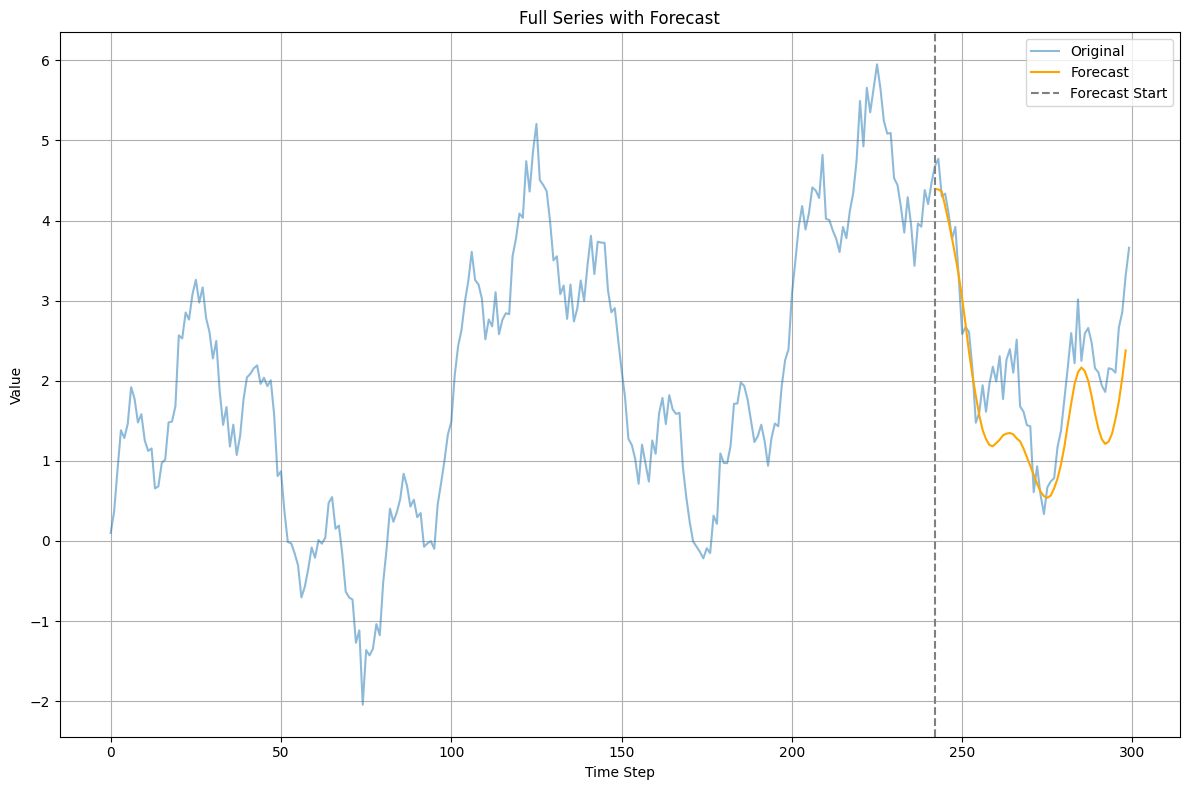


Training baseline model without NHA...


Training:  56%|█████▌    | 56/100 [00:01<00:01, 33.34epoch/s]

Epoch 50: Train Loss = 0.3392


Training: 100%|██████████| 100/100 [00:03<00:00, 33.18epoch/s]

Epoch 100: Train Loss = 0.1063

Validation Forecast Error Metrics:
  MSE   = 0.946510
  RMSE  = 0.972887
  MAE   = 0.762679
Baseline validation metrics: {'mse': np.float32(0.94650966), 'rmse': np.float32(0.9728873), 'mae': np.float32(0.76267904)}


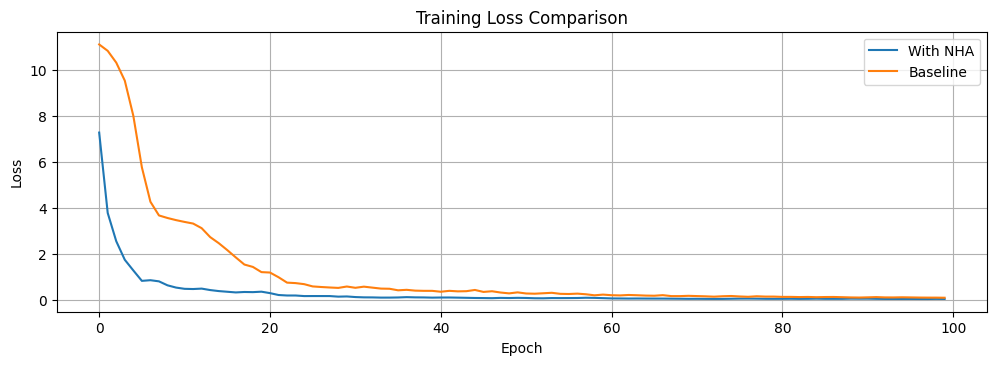

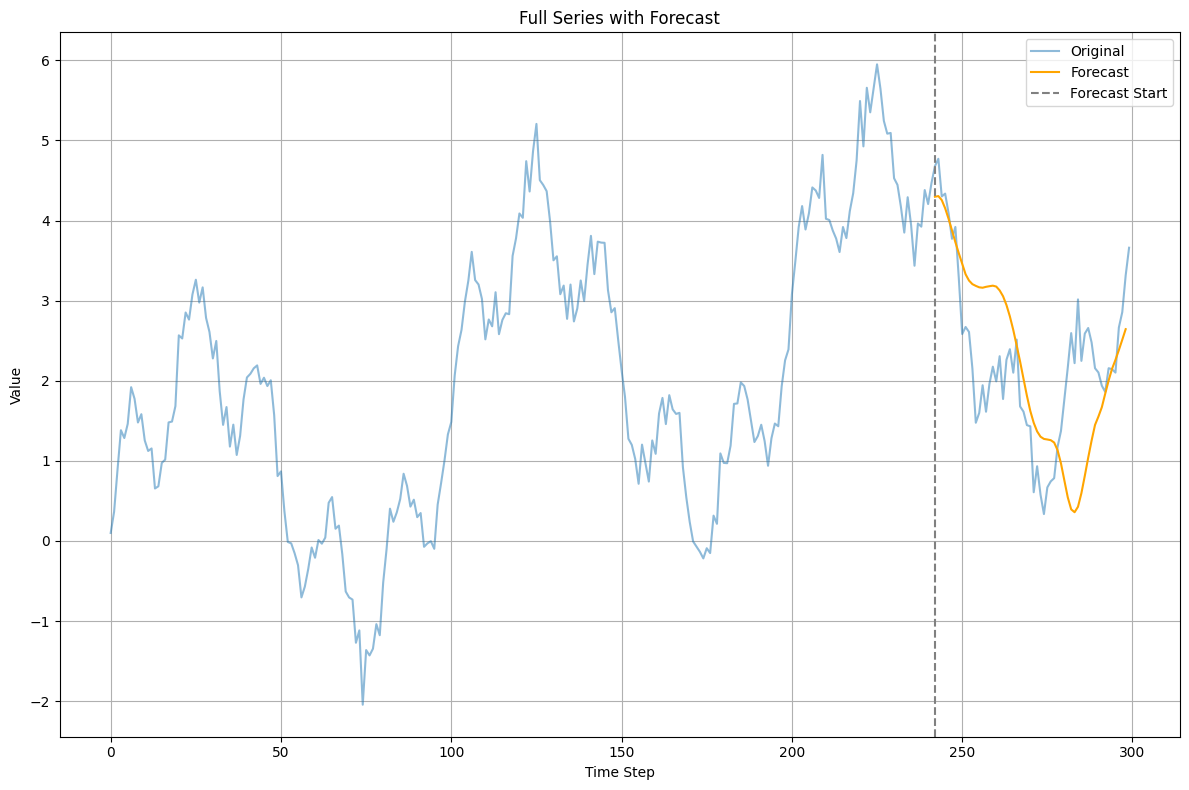

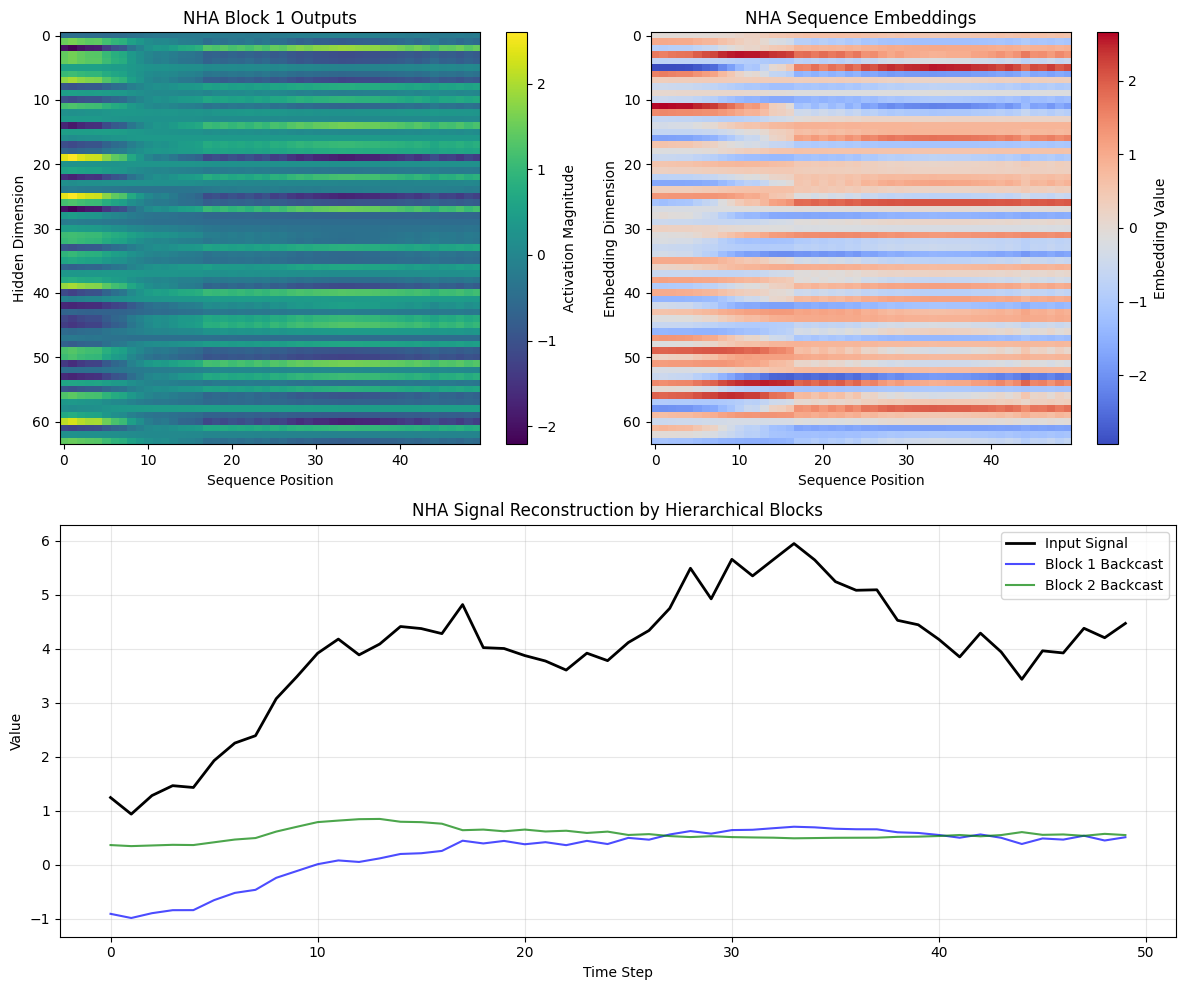

NHA enhanced model performance metrics:
With NHA: {'mse': np.float32(0.34454596), 'rmse': np.float32(0.5869804), 'mae': np.float32(0.491322)}
Baseline: {'mse': np.float32(0.94650966), 'rmse': np.float32(0.9728873), 'mae': np.float32(0.76267904)}
Improvement in MSE: 63.60%


In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from foreblocks import ForecastingModel
from foreblocks import LSTMDecoder, LSTMEncoder
from foreblocks import Trainer
from foreblocks.att import AttentionLayer

# Import the NHA model we created
from foreblocks.blocks.nha import NHA

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Parameters
input_size = 1
hidden_size = 64
embedding_size = 64  # NHA output embedding size
num_layers = 1
output_size = 1
target_len = 10
seq_len = 50
total_len = 300  # Total synthetic time series length

# 1. Create the NHA input preprocessor
nha_preprocessor = NHA(
    input_dim=input_size,              # Input dimension
    embedding_dim=embedding_size,      # Output embedding dimension
    hidden_dim=hidden_size,            # Hidden dimension for processing
    num_blocks=2,                      # Number of hierarchical blocks
    num_levels_per_block=3,            # Number of hierarchical levels per block
    kernel_size=3,                     # Kernel size for convolutions
    attention_heads=4,                 # Number of attention heads
    dropout=0.1,                       # Dropout probability
    pooling="attention"                # How to aggregate sequence information
)

# Define a wrapper class to match the expected interface for input_preprocessor
class NHAPreprocessor(nn.Module):
    def __init__(self, nha_model):
        super().__init__()
        self.nha_model = nha_model
        
    def forward(self, x):
        # x shape: [batch_size, seq_len, input_dim]
        # Return sequence embeddings to match expected interface
        sequence_embeddings, _ = self.nha_model(x, return_sequence=True)
        return sequence_embeddings

# Wrap the NHA model 
nha_wrapper = NHAPreprocessor(nha_preprocessor)

# 2. Create encoder and decoder
encoder = LSTMEncoder(
    input_size=embedding_size,  # Now input size matches NHA output embedding size
    hidden_size=hidden_size,
    num_layers=num_layers
)

decoder = LSTMDecoder(
    input_size=output_size,
    hidden_size=hidden_size,
    output_size=output_size,
    num_layers=num_layers
)

# Optional attention module
attention_module = AttentionLayer(
    method='dot',
    attention_backend='xformers',
    encoder_hidden_size=hidden_size,
    decoder_hidden_size=hidden_size,
)

# 3. Create the model with NHA as input_preprocessor
model = ForecastingModel(
    encoder=encoder,
    decoder=decoder,
    target_len=target_len,
    forecasting_strategy="seq2seq",
    teacher_forcing_ratio=0.5,
    output_size=output_size,
    input_skip_connection=True,
    input_preprocessor=nha_wrapper,      # Use our NHA block
    attention_module=attention_module,   # Use attention with NHA
)

# 4. Set up trainer
trainer = Trainer(
    model, 
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    criterion=nn.MSELoss()
)

# 5. Generate synthetic time series with multiple frequency components
t = np.linspace(0, 6 * np.pi, total_len)
# Combine a slow-varying trend, seasonal component, and noise
time_series = (
    0.2 * t +                                  # Linear trend
    2.0 * np.sin(t) +                          # Main frequency
    0.8 * np.sin(5 * t) +                      # Higher frequency component
    0.4 * np.sin(0.2 * t) +                    # Low frequency component
    0.2 * np.random.randn(total_len)           # Noise
)
time_series = torch.tensor(time_series, dtype=torch.float32).unsqueeze(-1)  # Shape: [T, 1]

# 6. Prepare sliding windows for training
def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]

# 7. Create DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 8. Train the model
print("Training model with NHA input processor...")
history = trainer.train(train_loader, epochs=100)  # Increase epochs for better results

# 9. Evaluate the model
metrics = trainer.metrics(X_val, Y_val)
print(f"Validation metrics: {metrics}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 10. Make predictions on validation set
with torch.no_grad():
    X_val = X_val.to(device)
    predictions = model(X_val)

# Plot input sequence
pred_plot = trainer.plot_prediction(X_val, Y_val, full_series=time_series, offset=train_size)
plt.show()

# 12. Ablation study: Compare with a model without NHA
print("\nTraining baseline model without NHA...")

# Create baseline model without NHA
encoder_baseline = LSTMEncoder(input_size, hidden_size, num_layers)
decoder_baseline = LSTMDecoder(output_size, hidden_size, output_size, num_layers)

model_baseline = ForecastingModel(
    encoder=encoder_baseline,
    decoder=decoder_baseline,
    target_len=target_len,
    forecasting_strategy="seq2seq",
    teacher_forcing_ratio=0.5,
    output_size=output_size,
    # No input_preprocessor here
)

trainer_baseline = Trainer(
    model_baseline, 
    optimizer=torch.optim.Adam(model_baseline.parameters(), lr=0.001),
    criterion=nn.MSELoss()
)

# Train baseline model
history_baseline = trainer_baseline.train(train_loader, epochs=100)

# Evaluate baseline model
metrics_baseline = trainer_baseline.metrics(X_val, Y_val)
print(f"Baseline validation metrics: {metrics_baseline}")

# Make predictions with baseline model
with torch.no_grad():
    predictions_baseline = model_baseline(X_val)

# Compare results
plt.figure(figsize=(12, 8))

# Plot training losses
plt.subplot(2, 1, 1)
plt.plot(history['train_losses'], label='With NHA')
plt.plot(history_baseline['train_losses'], label='Baseline')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# Plot predictions for model with NHA
pred_plot_baseline = trainer_baseline.plot_prediction(X_val, Y_val, full_series=time_series, offset=train_size)
plt.show()

# Analysis of NHA's impact
# Create a visualization of NHA's hierarchical embeddings
plt.figure(figsize=(12, 10))

# Extract hierarchical features for analysis
with torch.no_grad():
    # Take a single sample for visualization
    sample_input = X_val[0:1]
    hierarchical_features = nha_preprocessor.extract_hierarchical_features(sample_input)

    # Visualize attention patterns if possible
    plt.subplot(2, 2, 1)
    try:
        # Get the first block's attention weights (this requires modifying NHA to store attention weights)
        # This is a placeholder - actual extraction depends on NHA implementation details
        block_outputs = hierarchical_features['block_outputs'][0][0].cpu().numpy()  # First batch, first block
        plt.imshow(block_outputs.T, aspect='auto', cmap='viridis')
        plt.colorbar(label='Activation Magnitude')
        plt.title('NHA Block 1 Outputs')
        plt.ylabel('Hidden Dimension')
        plt.xlabel('Sequence Position')
    except Exception as e:
        plt.text(0.5, 0.5, f"Could not visualize attention: {str(e)}", 
                horizontalalignment='center', verticalalignment='center',
                transform=plt.gca().transAxes, fontsize=10)

    # Visualize sequence embedding
    plt.subplot(2, 2, 2)
    try:
        sequence_embedding = hierarchical_features['sequence_embedding'][0].cpu().numpy()  # First batch
        plt.imshow(sequence_embedding.T, aspect='auto', cmap='coolwarm')
        plt.colorbar(label='Embedding Value')
        plt.title('NHA Sequence Embeddings')
        plt.ylabel('Embedding Dimension')
        plt.xlabel('Sequence Position')
    except Exception as e:
        plt.text(0.5, 0.5, f"Could not visualize embeddings: {str(e)}", 
                horizontalalignment='center', verticalalignment='center',
                transform=plt.gca().transAxes, fontsize=10)

    # Compare input and reconstructed signals (backcast)
    plt.subplot(2, 1, 2)
    try:
        input_signal = sample_input[0, :, 0].cpu().numpy()
        backcasts = [b[0, :, 0].cpu().numpy() for b in hierarchical_features['backcasts']]
        
        plt.plot(input_signal, 'k-', label='Input Signal', linewidth=2)
        
        # Plot backcasts from different hierarchical blocks
        colors = ['b', 'g', 'r', 'purple', 'orange']
        for i, backcast in enumerate(backcasts):
            if i < len(colors):
                plt.plot(backcast, color=colors[i], linestyle='-', label=f'Block {i+1} Backcast', alpha=0.7)
        
        plt.title('NHA Signal Reconstruction by Hierarchical Blocks')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.grid(True, alpha=0.3)
        plt.legend()
    except Exception as e:
        plt.text(0.5, 0.5, f"Could not visualize signal reconstruction: {str(e)}", 
                horizontalalignment='center', verticalalignment='center',
                transform=plt.gca().transAxes, fontsize=10)

plt.tight_layout()
plt.show()

print("NHA enhanced model performance metrics:")
print(f"With NHA: {metrics}")
print(f"Baseline: {metrics_baseline}")
improvement = (metrics_baseline['mse'] - metrics['mse']) / metrics_baseline['mse'] * 100
print(f"Improvement in MSE: {improvement:.2f}%")